<a href="https://colab.research.google.com/github/egorneo/Course-work/blob/main/ML_draw_GNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -Uq torch_geometric

In [ ]:
import sys
!wget https://raw.githubusercontent.com/egorneo/Course-work/main/dataset.py
!wget https://github.com/egorneo/Course-work/raw/main/data.zip
!unzip -y data.zip


#Old way with conda env
#from google.colab import drive
#drive.mount('/content/drive')
#!cp ./drive/Othercomputers/Comp/GNN/dataset.py ./
#!pip install -q virtualenv
#!source /content/drive/MyDrive/colab_env/bin/activate;
#sys.path.append("/content/drive/MyDrive/colab_env/lib/python3.10/site-packages")

--2024-04-04 19:30:29--  https://raw.githubusercontent.com/egorneo/Course-work/main/dataset.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1150 (1.1K) [text/plain]
Saving to: ‘dataset.py’

dataset.py          100%[===================>]   1.12K  --.-KB/s    in 0s      

2024-04-04 19:30:29 (80.1 MB/s) - ‘dataset.py’ saved [1150/1150]

--2024-04-04 19:30:29--  https://github.com/egorneo/Course-work/raw/main/data.zip
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/egorneo/Course-work/main/data.zip [following]
--2024-04-04 19:30:30--  https://raw.githubusercontent.com/egorneo/Course-work/main/da

In [ ]:
import os
import torch
print(torch.__version__)

2.2.1+cu121


In [ ]:
from torch_geometric.data import DataLoader
from dataset import DessinsDataset
import torch_geometric

dataset = DessinsDataset('./data', None)
print("Dataset len =", len(dataset))
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Device: {}'.format(device))

Dataset len = 1860
Device: cuda


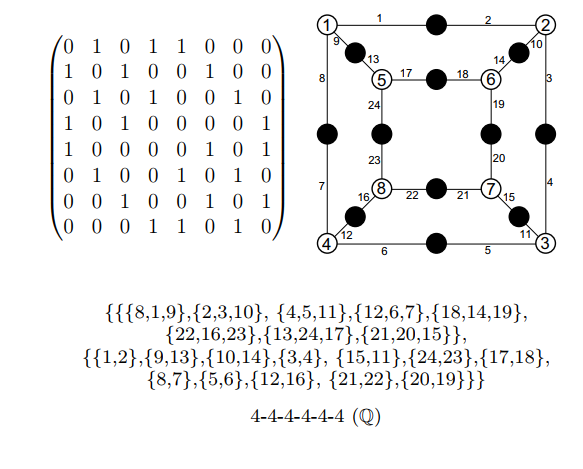

In [ ]:
N = 0
print(dataset[N])
# print(dataset[N].edge_index.t()[:15])
# print("Edge weights = ", dataset[N].weight)
# print(dataset[N].x)
# print(dataset[N].y)

Data(edge_index=[2, 48], weight=[48], x=[20, 3], y=[1])


In [ ]:
class_weights = [list(dataset.y).count(i)/len(dataset) for i in range(4)]
assert (sum(class_weights) == 1)

class_weights = torch.tensor(sorted(class_weights, reverse = True))
print("class_weights =", class_weights)

class_weights = tensor([0.4032, 0.3387, 0.2258, 0.0323])


In [ ]:
dataset = dataset.shuffle()


train_dataset = dataset[:int(len(dataset)*0.8)]
test_dataset = dataset[int(len(dataset)*0.8):]


print(f'Number of training graphs: {len(train_dataset)}')
print(f'Number of test graphs: {len(test_dataset)}')
print(f'Number of node features:{dataset.num_node_features}')
print(f'Number of classes:{dataset.num_classes}')

Number of training graphs: 1488
Number of test graphs: 372
Number of node features:3
Number of classes:4


Объявим функцию, формирующeю DataLoader'ы. Присвоим классам вероятности так, чтобы внутри батча соблюдался баланс классов.

In [ ]:
from torch.utils.data import WeightedRandomSampler

def get_loader(dataset, batch_size, auto_balance = True):
  if auto_balance:
  # Вычисляем веса
    class_weights = [1/list(dataset.y).count(i) for i in range(4)]
    class_weights = torch.tensor(class_weights)

    #Присваиваем соответствующий вес каждому экземпляру в датасете
    #в соответствии с его классом

    sample_weights = [class_weights[data.y] for idx, data in enumerate(dataset)]

    sampler = WeightedRandomSampler(sample_weights, num_samples=
                                  len(sample_weights), replacement=True)

  else:
    sampler = None

  loader = DataLoader(dataset, batch_size=batch_size, sampler=sampler)
  return loader


In [ ]:
train_loader = get_loader(train_dataset, batch_size=512)
test_loader = get_loader(test_dataset, batch_size=256)

/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


Проверим, что наши батчи на самом деле сбалансированны

In [ ]:

sample_batch = list(list(train_loader)[0].y)
class_weights = [sample_batch.count(i)/len(sample_batch) for i in range(4)]
print("Class_weights = ",class_weights)

Class_weights =  [0.232421875, 0.267578125, 0.2109375, 0.2890625]


Опишем нашу модель

In [ ]:
from torch.nn import Linear
from torch.nn import BatchNorm1d
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.nn import global_mean_pool
from torch_geometric.nn.conv import GraphConv
from torch_geometric.nn.conv import GATConv
from torch_geometric.nn import Sequential

In [ ]:
from collections import OrderedDict
from torch.nn import ReLU
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers=3, lin_layers=3):
        super(GCN, self).__init__()
        self.last_assigned_token = None

        self.num_layers = num_layers
        self.lin_layers = lin_layers

        self.convs = torch.nn.ModuleList([GCNConv(input_dim,hidden_dim)] + [GCNConv(hidden_dim,hidden_dim)\
                                                                          for i in range(num_layers-1)])
        self.batch_norm = BatchNorm1d(hidden_dim)
        self.lins = torch.nn.ModuleList([Linear(hidden_dim, hidden_dim)for i in range(lin_layers-1)] + [Linear(hidden_dim, output_dim)])

    def reset_parameters(self):
        for conv in self.convs:
            conv.reset_parameters()
        for lin in self.lins:
            lin.reset_parameters()

    def forward(self, x, edge_index, weights, batch):
        # 1. Obtain node embeddings
        for i in range(self.num_layers):
          x = self.convs[i](x, edge_index, edge_weight=weights)
          x = x.relu()

        #x = self.convs(x, edge_index, edge_weight=weights)

        #x = self.attention(x, edge_index, edge_attr = weights)

        # 2. Readout layer
        x = global_mean_pool(x, batch)  # [batch_size, hidden_channels]
        x = self.batch_norm(x)
        self.last_assigned_token = x

        # 3. Apply a final classifier
        x = F.dropout(x, p=0.6, training=self.training)


        for i in range(self.lin_layers-1):
          x = self.lins[i](x)
          x = x.relu()
          x = F.dropout(x, p=0.25, training=self.training)

        x = self.lins[self.lin_layers-1](x) #Final layer
        return x


model = GCN(dataset.num_node_features,hidden_dim=128,output_dim=dataset.num_classes, num_layers=2, lin_layers=2).to(device)
print(model)

GCN(
  (convs): ModuleList(
    (0): GCNConv(3, 128)
    (1): GCNConv(128, 128)
  )
  (batch_norm): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (lins): ModuleList(
    (0): Linear(in_features=128, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=4, bias=True)
  )
)


In [ ]:
from IPython.display import Javascript
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
model.reset_parameters()


optimizer = torch.optim.AdamW(model.parameters())
criterion = torch.nn.CrossEntropyLoss()

def train(loader):
    model.train()

    # Iterate in batches over the training dataset.
    for data in loader:
      data = data.to(device)
      out = model(data.x, data.edge_index, data.weight.float(), data.batch)  # Perform a single forward pass.
      loss = criterion(out, data.y)  # Compute the loss.
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.
      optimizer.zero_grad()  # Clear gradients.


def test(loader):

  model.eval()
  correct = 0

  # Iterate in batches over the training/test dataset.
  for data in loader:
    data = data.to(device)
    with torch.no_grad():
      out = model(data.x, data.edge_index, data.weight.float(), data.batch)

    pred = out.argmax(dim=1) # Use the class with highest probability.
    correct += int((pred == data.y).sum())  # Check against ground-truth labels.


  return correct / len(loader.dataset)  # Derive ratio of correct predictions.


for epoch in range(1, 250):
  train(train_loader)
  train_acc = test(train_loader)
  if (epoch %20 == 0):
    print(f'Epoch: {epoch:03d}, Train Acc: {train_acc:.4f}')

print('--------------------')
test_acc = test(test_loader)
print(f'Test Acc: {test_acc:.4f}')



<IPython.core.display.Javascript object>

Epoch: 020, Train Acc: 0.5860
Epoch: 040, Train Acc: 0.7735
Epoch: 060, Train Acc: 0.7413
Epoch: 080, Train Acc: 0.6788
Epoch: 100, Train Acc: 0.7977
Epoch: 120, Train Acc: 0.7964
Epoch: 140, Train Acc: 0.8884
Epoch: 160, Train Acc: 0.8562
Epoch: 180, Train Acc: 0.9792
Epoch: 200, Train Acc: 0.8999
Epoch: 220, Train Acc: 0.9711
Epoch: 240, Train Acc: 0.8858
--------------------
Test Acc: 0.9919


# Let us explain our model

In [ ]:
from torch_geometric.explain import Explainer, GNNExplainer
import networkx as nx

In [ ]:
#@title Fixed behavior of some library functions
from math import sqrt
from typing import Any, Optional

import torch
from torch import Tensor

BACKENDS = {'graphviz', 'networkx'}
from math import sqrt
def visualize_graph(
    edge_index: Tensor,
    edge_weight: Optional[Tensor] = None,
    path: Optional[str] = None,
    backend: Optional[str] = None,
) -> Any:
    r"""Visualizes the graph given via :obj:`edge_index` and (optional)
    :obj:`edge_weight`.

    Args:
        edge_index (torch.Tensor): The edge indices.
        edge_weight (torch.Tensor, optional): The edge weights.
        path (str, optional): The path to where the plot is saved.
            If set to :obj:`None`, will visualize the plot on-the-fly.
            (default: :obj:`None`)
        backend (str, optional): The graph drawing backend to use for
            visualization (:obj:`"graphviz"`, :obj:`"networkx"`).
            If set to :obj:`None`, will use the most appropriate
            visualization backend based on available system packages.
            (default: :obj:`None`)
    """
    if edge_weight is not None:  # Normalize edge weights.
        edge_weight = edge_weight - edge_weight.min()
        edge_weight = edge_weight / edge_weight.max()

    if edge_weight is not None:  # Discard any edges with zero edge weight:
        mask = edge_weight > 1e-7
        edge_index = edge_index[:, mask]
        edge_weight = edge_weight[mask]

    if edge_weight is None:
        edge_weight = torch.ones(edge_index.size(1))

    if backend is None:
        backend = 'graphviz' if has_graphviz() else 'networkx'

    if backend.lower() == 'networkx':
        return _visualize_graph_via_networkx(edge_index, edge_weight, path)
    elif backend.lower() == 'graphviz':
        return _visualize_graph_via_graphviz(edge_index, edge_weight, path)

    raise ValueError(f"Expected graph drawing backend to be in "
                     f"{BACKENDS} (got '{backend}')")


def _visualize_graph_via_graphviz(
    edge_index: Tensor,
    edge_weight: Tensor,
    path: Optional[str] = None,
) -> Any:
    import graphviz

    suffix = path.split('.')[-1] if path is not None else None
    g = graphviz.Digraph('graph', format=suffix)
    g.attr('node', shape='circle', fontsize='11pt')

    for node in edge_index.view(-1).unique().tolist():
        g.node(str(node))

    for (src, dst), w in zip(edge_index.t().tolist(), edge_weight.tolist()):
        hex_color = hex(255 - round(255 * w))[2:]
        hex_color = f'{hex_color}0' if len(hex_color) == 1 else hex_color
        g.edge(str(src), str(dst), color=f'#{hex_color}{hex_color}{hex_color}')

    if path is not None:
        path = '.'.join(path.split('.')[:-1])
        g.render(path, cleanup=True)
    else:
        g.view()

    return g

Explainer training

In [ ]:
explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='phenomenon',
    node_mask_type='attributes',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='graph',
        return_type='log_probs',  # Model returns log probabilities.
    ),
)

In [ ]:
from torch_geometric.explain import PGExplainer
explainer = Explainer(
    model=model,
    algorithm=PGExplainer(epochs=30, lr=0.003),
    explanation_type='phenomenon',
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='graph',
        return_type='log_probs',
    )
)

In [ ]:
for epoch in range(1):
  for data in train_loader:
    data = data.to(device)
    loss = explainer.algorithm.train(epoch, model, data.x, data.edge_index,
                                         target=data.y, weights = data.weight.float(), batch = data.batch)

In [ ]:
from torch_geometric.explain import metric

explain_loader = get_loader(train_dataset[0:50], batch_size=50,auto_balance=False)
for data in explain_loader:
  data = data.to(device)
  explanation = explainer(data.x, data.edge_index, weights=data.weight.float(), batch = data.batch )
  fids = metric.fidelity(explainer,explanation)
  #print(fids)
  #print(metric.characterization_score(fids[0],fids[1]))
  #explanation.visualize_feature_importance(top_k=10)
  #explanation.visualize_graph(backend='graphviz')
  visualize_graph(explanation.edge_index, explanation.weights.float(), backend='graphviz')
  #print(explanation)


In [ ]:
untchd_dataset = DessinsDataset('./drive/Othercomputers/Comp/GNN/data', None)
untchd_dataset[0]

In [ ]:
import graphviz
inst = untchd_dataset[7]
print(list(zip(inst.edge_index.t().tolist(), inst.weight.tolist())))
g = graphviz.Digraph('graph')

for node in inst.edge_index.contiguous().view(-1).unique().tolist():
        g.node(str(node))

for (src, dst), w in zip(inst.edge_index.t().tolist(), inst.weight.float().tolist()):
    g.edge(str(src), str(dst), label = str(int(w)))

g.render(filename='graph_7')
g

In [ ]:

print(inst.edge_index.t().contiguous())
print(inst.weight.float())
# print(inst.edge_index.stride())
# print(inst.edge_index.is_contiguous())
# print(inst.edge_index.contiguous().stride())
# print(inst.edge_index.shape)
#visualize_graph_via_networkx_custom(inst.edge_index, inst.weight.float())
dummy = torch.ones(len(inst.weight))
print(dummy)
visualize_graph(inst.edge_index, inst.weight.float(), backend='graphviz')

In [ ]:
mask = explanation.get('edge_mask')
mask

In [ ]:

inst = untchd_dataset[7]
print(list(zip(inst.edge_index.t().tolist(), mask.tolist())))
g = graphviz.Digraph('graph')

for node in inst.edge_index.contiguous().view(-1).unique().tolist():
        g.node(str(node))

for (src, dst), w, l in zip(inst.edge_index.t().tolist(), mask.tolist(), inst.weight.float().tolist()):
    hex_color = hex(255 - round(255 * w))[2:]
    hex_color = f'{hex_color}0' if len(hex_color) == 1 else hex_color
    print(f'#{hex_color}{hex_color}{hex_color}')
    g.edge(str(src), str(dst), color=f'#{hex_color}{hex_color}{hex_color}', label = str(int(l)))
    #g.edge(str(src), str(dst), label = str(int(w)))

g
g.render(filename='weighted_graph_7')

In [ ]:
visualize_graph(self.edge_index, edge_mask, path, backend)